<sup>This notebook is originally from https://github.com/lizanafj/POE_techniques and licensed for reuse under [MIT license].</sup>

# Airtightness diagnosis
---

This notebook is part of a set of data-based fault detection and diagnosis techniques. 

Specifically, this notebook characterises the **seasonal air change rate (ACH, h<sup>-1</sup>) of the building related to air infiltration and/or ventilation through the $CO_{2}$-based decay method**, following the approach defined by López-García et al. [1].

**The CO2-based decay method to calculate ACH (h<sup>-1</sup>):**

This method calculates the ventilation rates associated with infiltration, and natural and mechanical ventilation in buildings, since ventilation is the only significant process for carbon dioxide removal in the indoor environment. According to laboratory tests, this method shows an accuracy of ±10% and has been widely applied to evaluate ventilation ranges in buildings.

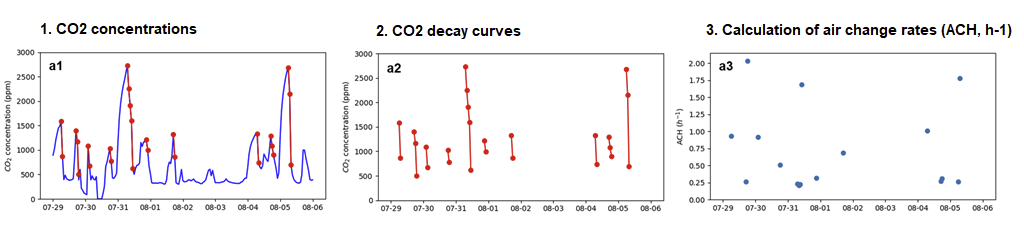

Limitations:

This method has two main limitations when applied to a real environment. ACHs should be obtained from $CO_{2}$ concentration decay curves when rooms are unoccupied. Thus, additional assumptions should be considered in order to reduce the number of erroneous ACH values if no occupancy sensors are used. Moreover, in the case of rooms coupled with other rooms, it should be considered that any $CO_{2}$ decrease may be related to air coupling and mixing between rooms rather than to ventilation.


References:

[1] López-García, E., Lizana, J., Serrano-Jiménez, A., Díaz-López, C., & Ángela Barrios-Padura. (2022). Monitoring and analytics to measure heat resilience of buildings and support retrofitting by passive cooling. Journal of Building Engineering, 57(July), 104985. https://doi.org/10.1016/j.jobe.2022.104985

In [28]:
import os

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import datetime

import warnings
warnings.filterwarnings("ignore")

# get folder location of script
cwd = os.getcwd()

## Import data
---
Import required data to perform the analysis

In [14]:
#Access to folder with data: 
os.chdir(cwd)
cwd_data = cwd+r"\Data"
os.chdir(cwd_data)

In [15]:
#data
data = pd.read_csv('HH_Indoor_Office_CO2sensor_2.csv',sep=";",index_col = "Time", parse_dates=True).tz_localize(None)

data_co2 = data[["CO2"]]

## Explore data
---
See variables, datetime, and data structure.

In [16]:
#See dataframe
data_co2.head()

,CO2
Time,
2022-05-06 11:00:00,455.955000
2022-05-06 12:00:00,416.655500
2022-05-06 13:00:00,400.155333
2022-05-06 14:00:00,413.641500
2022-05-06 15:00:00,402.409250


<AxesSubplot:xlabel='Time'>

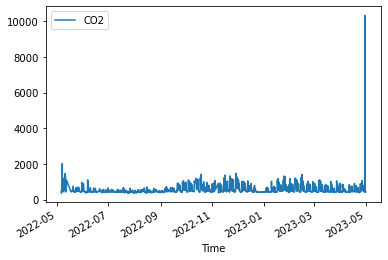

In [17]:
#Visualise variable
data_co2.plot()

## Data pre-processing
---

Filtering and cleaning steps before the analysis 


In [18]:
#eliminate outliers
data_co2 = data_co2[(data_co2["CO2"]<5000)]

<AxesSubplot:xlabel='Time'>

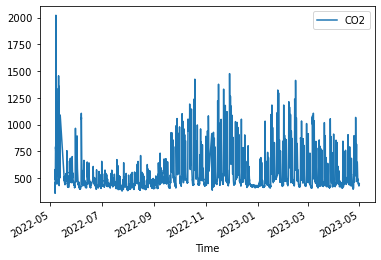

In [19]:
data_co2.plot()

In [20]:
#truncate timeframe
data_co2 = data_co2.truncate(before="2022-10-01",after="2023-03-31 23:00")

In [23]:
data_co2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4223 entries, 2022-10-01 00:00:00 to 2023-03-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO2     4223 non-null   float64
dtypes: float64(1)
memory usage: 66.0 KB


## Data diagnosis
---
Calculation of seasonal air change rate (ACH, h<sup>-1</sup>) of the building

In [25]:
#Function to calculate gradient
def co2gradient(data):   

    grad_co2=np.diff(data['CO2'])
    
    data=data[:-1]
    data['grad_co2']=grad_co2

    data['grad_co2'] = data['grad_co2'].fillna(0)

    return data

#Function to calculate ACH based on CO2-based decay method
def ACH(data):
    
    data=data.reset_index()
    
    AER_total=np.zeros(0)
    Cext=450
    
    for i in data.index:
        if i==0:
            AER_i=0
            AER_total=np.append(AER_total,AER_i)
        
        else:
            
            if  data.loc[i,'grad_co2']>=-50 or data.loc[i,'CO2']<1000:
                AER_i=0
                AER_total=np.append(AER_total,AER_i)
            
            else:              
                
            
                A=data[data.index==i].CO2
                B=data[data.index==i+1].CO2
                AER_i= np.log((int(A)-Cext)/(int(B)-Cext))        
        
                AER_total=np.append(AER_total,AER_i)
            
    data['ACH']=AER_total
    data=data.set_index('Time')

    data.loc[data.grad_co2>-50,'ACH']=np.nan
    data.loc[data.ACH<=0, 'ACH']=np.nan

    return data

#Function to plot the whole calculation process
def tramos(data):
    data=data.reset_index()
    
    for i in data.index:
        if np.isnan(data.loc[i,'ACH']):
            data.loc[i,'valor']=0
        else:
            data.loc[i,'valor']=1
        
    for i in data.index:
        if np.isnan(data.loc[i,'ACH']):
            data.loc[i+1,'valor_sig']=0
        else:
            data.loc[i+1,'valor_sig']=1
        
    for i in data.index:
        if (data.loc[i,'valor']==1) or(data.loc[i,'valor_sig']==1):
            data.loc[i, 'CO2_valid']=1
    
        else:
            data.loc[i, 'CO2_valid']=0
            
    del data['valor']
    del data['valor_sig']
    
    data=data.set_index('Time')

    #Add CO2 decay concentrations selected for calculation 
    data["CO2_used"] = data["CO2"]
    data.loc[data.grad_co2>-50,'CO2_used']=np.nan
    data.loc[data.CO2_valid ==0,'CO2_used']=np.nan
    data.loc[data.ACH<=0, 'ACH']=np.nan

    #sorted index
    data.sort_index()
    data = data[:-1]

    return data

In [29]:
#Apply functions to dataframe

#function 1
data1 = co2gradient(data_co2)
data1.head()

,CO2,grad_co2
Time,,
2022-10-01 00:00:00,557.13250,-20.23575
2022-10-01 01:00:00,536.89675,-11.72975
2022-10-01 02:00:00,525.16700,-18.31500
2022-10-01 03:00:00,506.85200,-13.32075
2022-10-01 04:00:00,493.53125,-9.29675


In [30]:
#function 2
data2= ACH(data1)
data2.head()

,CO2,grad_co2,ACH
Time,,,
2022-10-01 00:00:00,557.13250,-20.23575,NaN
2022-10-01 01:00:00,536.89675,-11.72975,NaN
2022-10-01 02:00:00,525.16700,-18.31500,NaN
2022-10-01 03:00:00,506.85200,-13.32075,NaN
2022-10-01 04:00:00,493.53125,-9.29675,NaN


In [31]:
#function 3
data3 =tramos(data2)
data3.head()

,CO2,grad_co2,ACH,CO2_valid,CO2_used
Time,,,,,
2022-10-01 00:00:00,557.13250,-20.23575,NaN,0.0,NaN
2022-10-01 01:00:00,536.89675,-11.72975,NaN,0.0,NaN
2022-10-01 02:00:00,525.16700,-18.31500,NaN,0.0,NaN
2022-10-01 03:00:00,506.85200,-13.32075,NaN,0.0,NaN
2022-10-01 04:00:00,493.53125,-9.29675,NaN,0.0,NaN


In [32]:
stats_co2 = data3[["ACH"]].describe()

In [34]:
print(stats_co2)

             ACH
count  89.000000
mean    0.133290
std     0.046635
min     0.062312
25%     0.093672
50%     0.126448
75%     0.164464
max     0.280986


## Data visualisation
---

Visualisation of all dataset

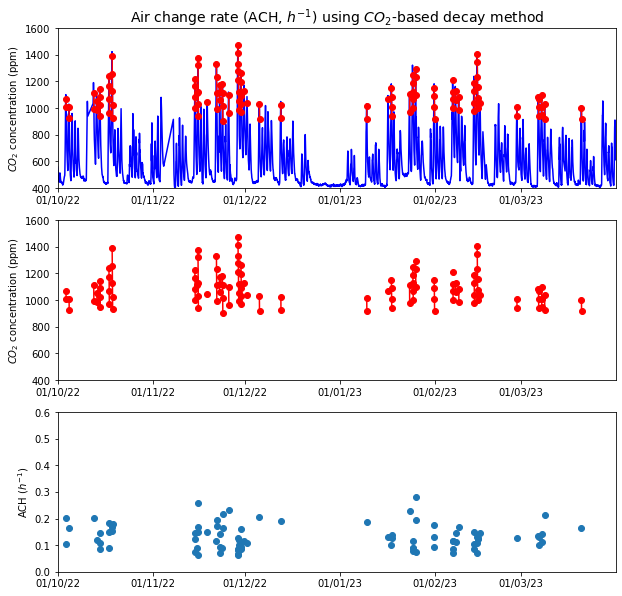

In [45]:
fig, axs = plt.subplots(3,1,figsize=(10, 10))

axs[0].set_title('Air change rate (ACH, $h^{-1}$) using $CO_{2}$-based decay method', fontsize=14)

axs[0].plot(data3.index, data3['CO2'],'blue')
axs[0].plot(data3.index, data3['CO2_used'], 'o-r')
axs[0].set_ylabel('$CO_{2}$ concentration (ppm)')
axs[0].set_xlim(data3.index[0],data3.index[-1])
axs[0].set(ylim=(400, 1600))

axs[1].plot(data3.index, data3['CO2_used'], 'o-r')
axs[1].set_ylabel('$CO_{2}$ concentration (ppm)')
axs[1].set_xlim(data3.index[0],data3.index[-1])
axs[1].set(ylim=(400, 1600))

axs[2].plot(data3.index, data3['ACH'],'o')
axs[2].set_ylabel('ACH ($h^{-1}$)')
axs[2].set_xlim(data3.index[0],data3.index[-1])
axs[2].set(ylim=(0, 0.6))

# Define the date format
axs[0].xaxis.set_major_formatter(DateFormatter("%d/%m/%y"))
axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axs[1].xaxis.set_major_formatter(DateFormatter("%d/%m/%y"))
axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axs[2].xaxis.set_major_formatter(DateFormatter("%d/%m/%y"))
axs[2].xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.show()

Visualisation of one week

In [39]:
before='2022-11-10'
after='2022-12-20'

In [40]:
data4 = data3.truncate(before = before, after=after)

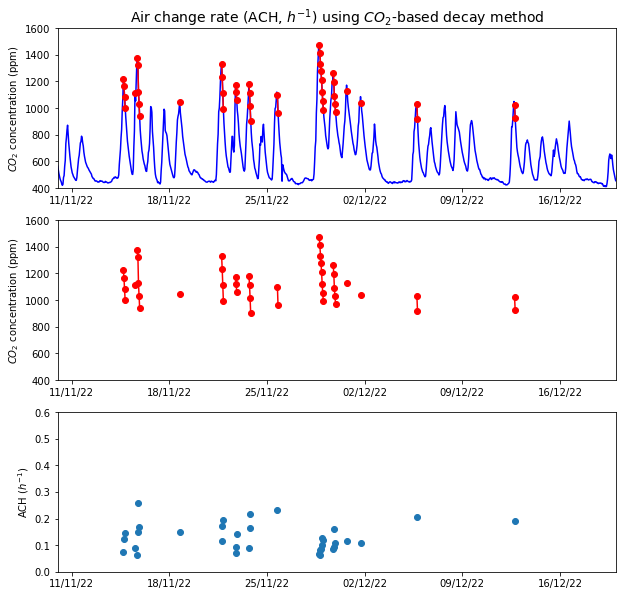

In [46]:
fig, axs = plt.subplots(3,1,figsize=(10, 10))

axs[0].set_title('Air change rate (ACH, $h^{-1}$) using $CO_{2}$-based decay method', fontsize=14)

axs[0].plot(data4.index, data4['CO2'],'blue')
axs[0].plot(data4.index, data4['CO2_used'], 'o-r')
axs[0].set_ylabel('$CO_{2}$ concentration (ppm)')
axs[0].set_xlim(data4.index[0],data4.index[-1])
axs[0].set(ylim=(400, 1600))

axs[1].plot(data4.index, data4['CO2_used'], 'o-r')
axs[1].set_ylabel('$CO_{2}$ concentration (ppm)')
axs[1].set_xlim(data4.index[0],data4.index[-1])
axs[1].set(ylim=(400, 1600))

axs[2].plot(data4.index, data4['ACH'],'o')
axs[2].set_ylabel('ACH ($h^{-1}$)')
axs[2].set_xlim(data4.index[0],data4.index[-1])
axs[2].set(ylim=(0, 0.6))

# Define the date format
axs[0].xaxis.set_major_formatter(DateFormatter("%d/%m/%y"))
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=7))
axs[1].xaxis.set_major_formatter(DateFormatter("%d/%m/%y"))
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval=7))
axs[2].xaxis.set_major_formatter(DateFormatter("%d/%m/%y"))
axs[2].xaxis.set_major_locator(mdates.DayLocator(interval=7))

plt.show()

Visualisation using violing plot

In [49]:
#statistics
ach_75 = data3['ACH'].quantile(0.75)
ach_75 = round(ach_75, 2)
ach_median = data3['ACH'].median()
ach_median = round(ach_median, 2)
ach_mean = data3['ACH'].mean()
ach_mean = round(ach_mean, 2)
number = data3['ACH'].dropna().size

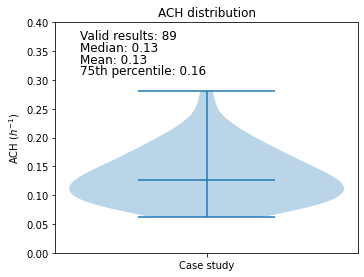

In [51]:
#Violing plot
data_violin=data3['ACH'].dropna()
labels=['Case study']
fig = plt.figure()

# Create an axes instance
ax = fig.add_axes([0,0,0.7,0.8])

# Create the boxplot
bp = ax.violinplot(data_violin,showmedians=True)
ax.set_xticks(np.arange(1, len(labels) + 1))
ax.set_xticklabels(labels)
ax.set(ylim=(0, 0.4))
ax.set_ylabel('ACH ($h^{-1}$)')
ax.set_title('ACH distribution')
plt.text(0.77, 0.37, f'Valid results: {number} ',fontsize=12)
plt.text(0.77, 0.35, f'Median: {ach_median} ',fontsize=12)
plt.text(0.77, 0.33, f'Mean: {ach_mean} ',fontsize=12)
plt.text(0.77, 0.31, f'75th percentile: {ach_75} ',fontsize=12)

plt.show()  